In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import random

import librosa
import math

In [2]:
DATA_PATH = "./data_10.json"

In [3]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [4]:
# load data
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [5]:
X.shape

(9986, 130, 13)

In [6]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Simple ANN

In [7]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [8]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [10]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
219/219 [==============================] - 8s 26ms/step - loss: 6.7789 - accuracy: 0.2621 - val_loss: 2.2184 - val_accuracy: 0.2016

In [11]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

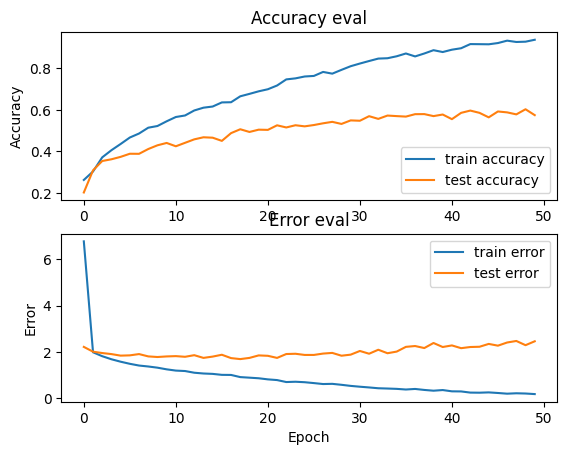

In [12]:
# plot accuracy and error as a function of the epochs
plot_history(history)

Managing Overfitting

In [13]:
# build network topology
model_regularized = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [14]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_regularized.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# train model
history = model_regularized.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
219/219 [==============================] - 4s 16ms/step - loss: 23.3787 - accuracy: 0.1774 - val_loss: 3.5627 - val_accuracy: 0.2660

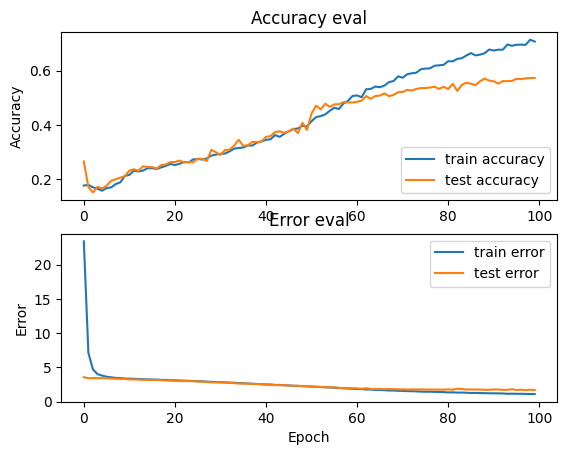

In [16]:
# plot accuracy and error as a function of the epochs
plot_history(history)

Convolutional Neural Network

In [17]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [18]:
X_train.shape

(5991, 130, 13, 1)

In [19]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [20]:
# build the CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [21]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 64)         36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 64)        0         
 2D)                                                             
                                                      

In [23]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
188/188 [==============================] - 20s 99ms/step - loss: 2.2501 - accuracy: 0.2636 - val_loss: 1.7457 - val_accuracy: 0.3952

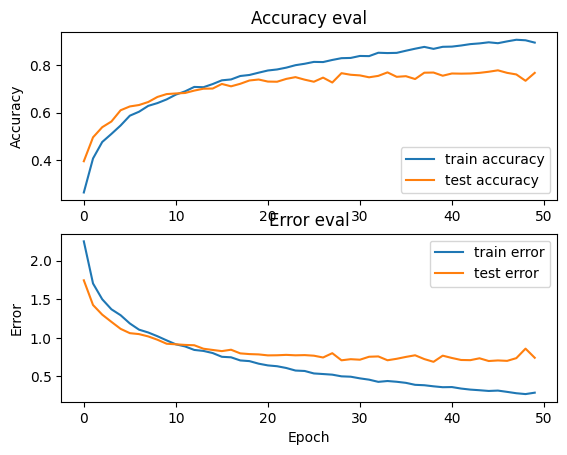

In [24]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [25]:
# evaluate model on Test Set
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 2s - loss: 0.7675 - accuracy: 0.7577 - 2s/epoch - 31ms/step

Test accuracy: 0.757709264755249


In [26]:
#model_cnn.save("Music_Genrel_CNN_Model.h5")

In [27]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("Music_Genrel_CNN_Model.h5")

Prediction on Test Set

In [28]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [29]:
X_to_predict.shape

(130, 13, 1)

In [30]:
print("Real Genre:", y_to_predict)

Real Genre: 8


In [31]:
# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [32]:
X_to_predict.shape

(1, 130, 13, 1)

In [33]:
# perform prediction
prediction = model_cnn.predict(X_to_predict)

1/1 [==============================] - 0s 196ms/step


In [34]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Predicted Genre: 8


In [35]:
# pick a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 1
1/1 [==============================] - 0s 27ms/step
Predicted Genre: 1


In [36]:
len(X_test)

2497

In [37]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_cnn.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: 0
1/1 [==============================] - 0s 299ms/step
Predicted Genre: 0

Real Genre: 4
1/1 [==============================] - 0s 29ms/step
Predicted Genre: 3

Real Genre: 3
1/1 [==============================] - 0s 25ms/step
Predicted Genre: 8

Real Genre: 4
1/1 [==============================] - 0s 23ms/step
Predicted Genre: 4

Real Genre: 9
1/1 [==============================] - 0s 21ms/step
Predicted Genre: 1

Real Genre: 1
1/1 [==============================] - 0s 36ms/step
Predicted Genre: 1

Real Genre: 4
1/1 [==============================] - 0s 24ms/step
Predicted Genre: 8

Real Genre: 2
1/1 [==============================] - 0s 25ms/step
Pre

Prediction on New Songs

In [44]:
# Audio files pre-processing
def process_input(audio_file, track_duration):
    SAMPLE_RATE = 22050
    NUM_MFCC = 13
    N_FTT = 2048
    HOP_LENGTH = 512
    TRACK_DURATION = track_duration  # measured in seconds
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
    NUM_SEGMENTS = 10

    samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

    signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)

    mfcc_vectors = []  # List to store the MFCC vectors for each segment

    for d in range(NUM_SEGMENTS):
        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc
        mfcc = librosa.feature.mfcc(
            y=signal[start:finish],
            sr=sample_rate,
            n_mfcc=NUM_MFCC,
            n_fft=N_FTT,
            hop_length=HOP_LENGTH
        )
        mfcc = mfcc.T

        mfcc_vectors.append(mfcc)  # Append the extracted MFCC vectors to the list

    return mfcc_vectors

In [1]:
genre_dict = {
    0: "blues",
    1: "classical",
    2: "country",
    3: "disco",
    4: "hiphop",
    5: "jazz",
    6: "metal",
    7: "pop",
    8: "reggae",
    9: "rock"
}

def predict_genre(file_path):
    # Assuming there is a function called 'process_input' to process the audio file
    new_input_mfcc = process_input(file_path, 30)
    X_to_predict = np.array(new_input_mfcc)

    # Reshape X_to_predict to match the expected input shape of the model
    X_to_predict = X_to_predict.reshape(X_to_predict.shape[0], X_to_predict.shape[1], X_to_predict.shape[2], 1)

    prediction = reconstructed_model.predict(X_to_predict)

    # Get the most common predicted index
    predicted_index = np.argmax(np.bincount(prediction.argmax(axis=1)))
    predicted_genre = genre_dict[predicted_index]

    return predicted_genre

# Example usage
file_path = "./testing/1.mp3"
predicted_genre = predict_genre(file_path)
print("Predicted Genre:", predicted_genre)

NameError: name 'process_input' is not defined